In [5]:
import numpy as np
import os
import nibabel as nib
from nilearn import plotting
import matplotlib.pyplot as plt
from PIL import Image
import scipy.sparse
import scipy.misc

# Image Preprocessing & Data Cleaning Methods

In [6]:
def save_sparse_csr(filename, array):
    # note that .npz extension is added automatically
    np.savez(filename, data=array.data, indices=array.indices,
             indptr=array.indptr, shape=array.shape)

def load_sparse_csr(filename):
    # here we need to add .npz extension manually
    loader = np.load(filename + '.npz')
    return csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                      shape=loader['shape'])

In [7]:
def empty_img(img):
    """
    Returns True if the image is empty
    """
    return not np.count_nonzero(img)

def split_filename(filename):
    """
    Splits filename for a trial into 'trial10_30_w1', True if seg[label], False if vol[raw]
    """
    fn_lst = filename.split('_')
    if len(fn_lst) >= 4:
        trial_name = "_".join(fn_lst[:3])
        if 'seg' in fn_lst[3]:  
            return trial_name, True
        elif 'vol' in fn_lst[3]:
            return trial_name, False
    else:
        return None, None

In [8]:
matched_file_dict = {}  # Dictionary of trial_key to [seg_file, vol_file]
base_data_dir = "/Users/kireet/ucb/HART Research/Muscle Segmentation/raw_nifti_scan"
for filename in os.listdir(base_data_dir):
    trial_key, is_seg = split_filename(filename)
    if trial_key is not None:
        if trial_key not in matched_file_dict:
            matched_file_dict[trial_key] = [None, None]
        if is_seg:
            matched_file_dict[trial_key][1] = filename
        else:
            matched_file_dict[trial_key][0] = filename
        
from pprint import pprint
pprint(matched_file_dict)

{'trial10_30_w1': ['trial10_30_w1_volume_TRANS.nii',
                   'trial10_30_w1_seg2_TRANS.nii'],
 'trial12_30_w3': ['trial12_30_w3_volume_TRANS.nii',
                   'trial12_30_w3_seg_ak2_TRANS.nii'],
 'trial13_60_fs': ['trial13_60_fs_volume_TRANS.nii',
                   'trial13_60_fs_seg_TRANS.nii'],
 'trial15_60_w1': ['trial15_60_w1_volume_TRANS.nii',
                   'trial15_60_w1_seg_TRANS.nii'],
 'trial17_60_w3': ['trial17_60_w3_volume_TRANS.nii',
                   'trial17_60_w3_seg2_TRANS.nii'],
 'trial18_90_fs': ['trial18_90_fs_volume_TRANS.nii',
                   'trial18_90_fs_seg_TRANS.nii'],
 'trial20_90_w1': ['trial20_90_w1_volume_TRANS.nii',
                   'trial20_90_w1_seg_TRANS.nii'],
 'trial22_90_w3': ['trial22_90_w3_volume_TRANS.nii',
                   'trial22_90_w3_seg_TRANS.nii'],
 'trial8_30_fs': ['trial8_30_fs_volume_TRANS.nii',
                  'trial8_30_fs_seg_ak5_lh4_TRANS.nii']}


(1188, 482, 395)
(482, 395)
False


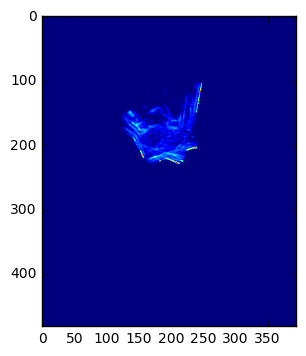

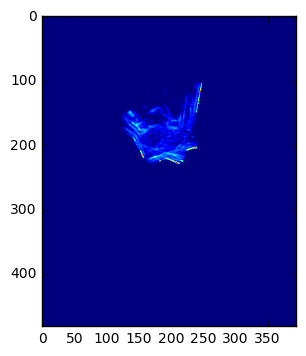

(482, 395)
(134, 126)


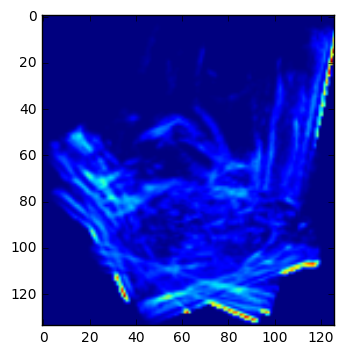

In [9]:
example_segmentation = os.path.join(base_data_dir, 'trial10_30_w1_seg2_TRANS.nii')
example_rawscan = os.path.join(base_data_dir, 'trial10_30_w1_volume_TRANS.nii')

scan_voxel = nib.load(example_rawscan)
print(scan_voxel.shape)

# plotting.plot_stat_map(img)
# plotting.show()

data1 = scan_voxel.get_data()
x = 400
for i in data1[x-1:x]:
    print(i.shape)
    print(empty_img(i))
#     print(i[200,:])
    plt.imshow(i)
    plt.show()
#     print(i.shape)
#     plotting.plot_stat_map(i)
#     plotting.show()
im = data1[x-1:x][0]
plt.imshow(im)
plt.show()
print(im.shape)

def bounding_box(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    box = im[rmin : rmax, cmin : cmax]
    return box
#     return rmin, rmax, cmin, cmax
box = bounding_box(im)
print(box.shape)
plt.imshow(box)
plt.show()

(1188, 482, 395)


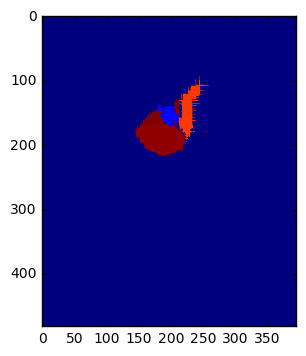

21.41768717765808


In [10]:
example_segmentation = os.path.join(base_data_dir, 'trial10_30_w1_seg2_TRANS.nii')
scan_voxel = nib.load(example_segmentation)
print(scan_voxel.shape)
data1 = scan_voxel.get_data()
x = 400
im = data1[x-1:x][0]

def fill(image, threshold_dist=10):
    rows, cols = len(image), len(image[0])
    for u in range(rows):  # Iterate through rows
        for v in range(cols):  # Iterate through cols
            ltr_color, gtr_color, ltc_color, gtc_color = False, False, False, False
            for ltr in range(u, max(0, u-threshold_dist), -1):
                if image[ltr, v] != 0: 
                    ltr_color = image[ltr, v]
                    break
            for gtr in range(u, min(rows, u+threshold_dist)):
                if image[gtr, v] != 0: 
                    gtr_color = image[gtr, v]
                    break
            for ltc in range(v, max(0, v-threshold_dist), -1):
                if image[u, ltc] != 0: 
                    ltc_color = image[u, ltc]
                    break
            for gtc in range(v, min(cols, v+threshold_dist)):
                if image[u, gtc] != 0: 
                    gtc_color = image[u, gtc]
                    break
            if np.all([ltr_color, gtr_color, ltc_color, gtc_color]):
                if len(set([ltr_color, gtr_color, ltc_color, gtc_color])) == 1:
                    image[u, v] = ltr_color
    return image

import time
start = time.time()
plt.imshow(fill(im))
plt.show()
end = time.time()
print(end - start)

In [11]:
base_img_data_dir = "/Users/kireet/ucb/HART Research/Muscle Segmentation/cleaned_sparse_images"

def build_sparse_image_dataset(trial_key, raw_nii, label_nii):
    raw_nii_file = os.path.join(base_data_dir, raw_nii)
    label_nii_file = os.path.join(base_data_dir, label_nii)
    raw_voxel = nib.load(raw_nii_file).get_data()
    label_voxel = nib.load(label_nii_file).get_data()
    
    raw_clean_voxel, labeled_clean_voxel = None, None
    for i in range(raw_voxel.shape[0]):  # shape is (1188, 482, 395)
        if empty_img(raw_voxel[i]) or empty_img(label_voxel[i]):
            continue
            
        raw_img = raw_voxel[i]
        labeled_img = fill(label_voxel[i])  # Grid fill the labeled image
        
        raw_sparse_mat = scipy.sparse.csr_matrix(raw_img)  # convert to sparse matrix
        labeled_sparse_mat = scipy.sparse.csr_matrix(labeled_img)
        
        if raw_clean_voxel is not None:
            scipy.sparse.hstack([raw_clean_voxel, raw_sparse_mat])
        else:
            raw_clean_voxel = raw_sparse_mat
        if labeled_clean_voxel is not None:
            scipy.sparse.hstack([labeled_clean_voxel, labeled_sparse_mat])
        else:
            labeled_clean_voxel = labeled_sparse_mat
            
    save_sparse_csr(os.path.join(base_img_data_dir, trial_key + '_raw'), raw_clean_voxel)  # Save the sparse matrices
    save_sparse_csr(os.path.join(base_img_data_dir, trial_key + '_labeled'), labeled_clean_voxel)
    

In [2]:
# Runs the cleaning image voxel dataset -> creates cleaned 3D voxels OR can convert to 2D images with some mods
for tk, scan_lst in list(matched_file_dict.items()):
    build_sparse_image_dataset(tk, scan_lst[0], scan_lst[1])
    break  # Remove break to create images for all scans

NameError: name 'matched_file_dict' is not defined

In [15]:
base_img_data_dir = "/Users/kireet/ucb/HART Research/Muscle Segmentation/cleaned_images"

def build_image_dataset(trial_key, raw_nii, label_nii):
    raw_nii_file = os.path.join(base_data_dir, raw_nii)
    label_nii_file = os.path.join(base_data_dir, label_nii)
    raw_voxel = nib.load(raw_nii_file).get_data()
    label_voxel = nib.load(label_nii_file).get_data()
    
    counter = 0
    trial_img_dir = os.path.join(base_img_data_dir, trial_key)
    if not os.path.exists(trial_img_dir):
        os.makedirs(trial_img_dir)
    raw_clean_voxel, labeled_clean_voxel = None, None
    for i in range(raw_voxel.shape[0]):  # shape is (1188, 482, 395)
        if empty_img(raw_voxel[i]) or empty_img(label_voxel[i]):
            continue
            
        raw_img = raw_voxel[i]
        labeled_img = fill(label_voxel[i])  # Grid fill the labeled image
        
        scipy.misc.imsave(os.path.join(trial_img_dir, str(counter) + '_raw.jpg'), raw_img)
        scipy.misc.imsave(os.path.join(trial_img_dir, str(counter) + '_label.jpg'), labeled_img)
        
        counter += 1
        
        if counter > 60:
            break

In [16]:
# Runs the cleaning image voxel dataset -> creates cleaned 2D jpegs
for tk, scan_lst in list(matched_file_dict.items()):
    build_image_dataset(tk, scan_lst[0], scan_lst[1])
    break  # Remove break to create images for all scans

# Modeling Data Setup

In [ ]:
# TODO: Determine if 512, 512 Data padding with zeros is necessary

x_train, y_train = [], []
x_val, y_val = [], []
x_test, y_test = [], []

for i in range(len(filenames)):
    filename = filenames[i]
    study = '_'.join(filename.split('_')[:4])
    if study in train_lst: 
        x_train.append(images[i])
        y_train.append(segmentations[i])
    else:
        x_test.append(images[i])
        y_test.append(segmentations[i])
                
x_train = np.array(x_train).reshape((len(x_train),im_size,im_size,1))
x_test = np.array(x_test).reshape((len(x_test),im_size,im_size,1))
y_train = np.array(y_train)
y_test = np.array(y_test)

# U-Net Model

In [ ]:
# Add Tensorflow or Keras U-Net here

h, w = 482, 395

class Unet(object):        
    def __init__(self, mean, weight_decay, learning_rate, label_dim = 8, dropout = 0.9):
        self.x_train = tf.placeholder(tf.float32, [None, h, w, 1])
        self.y_train = tf.placeholder(tf.float32, [None, h, w, 7])
        self.x_test = tf.placeholder(tf.float32, [None, h, w, 1])
        self.y_test = tf.placeholder(tf.float32, [None, h, w, 7])
        
        self.label_dim = label_dim
        self.weight_decay = weight_decay
        self.learning_rate = learning_rate
        self.dropout = dropout

        self.output = self.unet(self.x_train, mean, keep_prob=self.dropout)
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.output, labels = self.y_train))
        self.opt = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        
        self.pred = self.unet(self.x_test, mean, reuse = True, keep_prob = 1.0)
        self.loss_summary = tf.summary.scalar('loss', self.loss)
    
    # Gradient Descent on mini-batch
    def fit_batch(self, sess, x_train, y_train):
        _, loss, loss_summary = sess.run((self.opt, self.loss, self.loss_summary), feed_dict={self.x_train: x_train, self.y_train: y_train})
        return loss, loss_summary
    
    def predict(self, sess, x):
        prediction = sess.run((self.pred), feed_dict={self.x_test: x})
        return prediction

    
    def unet(self, input, mean, keep_prob = 0.9, reuse = None):
        with tf.variable_scope('vgg', reuse=reuse):
            input = input - mean
            pool_ = lambda x: nn.max_pool(x, 2, 2)
            conv_ = lambda x, output_depth, name, padding = 'SAME', relu = True, filter_size = 3: nn.conv(x, filter_size, output_depth, 1, self.weight_decay, 
                                                                                                           name=name, padding=padding, relu=relu)
            deconv_ = lambda x, output_depth, name: nn.deconv(x, 2, output_depth, 2, self.weight_decay, name=name)
            
            conv_1_1 = conv_(input, 64, 'conv1_1')
            conv_1_2 = conv_(conv_1_1, 64, 'conv1_2')

            pool_1 = pool_(conv_1_2)

            conv_2_1 = conv_(pool_1, 128, 'conv2_1')
            conv_2_2 = conv_(conv_2_1, 128, 'conv2_2')

            pool_2 = pool_(conv_2_2)

            conv_3_1 = conv_(pool_2, 256, 'conv3_1')
            conv_3_2 = conv_(conv_3_1, 256, 'conv3_2')

            pool_3 = pool_(conv_3_2)

            conv_4_1 = conv_(pool_3, 512, 'conv4_1')
            conv_4_2 = conv_(conv_4_1, 512, 'conv4_2')

            pool_4 = pool_(conv_4_2)

            conv_5_1 = conv_(pool_4, 1024, 'conv5_1')
            conv_5_2 = conv_(conv_5_1, 1024, 'conv5_2')
            
            pool_5 = pool_(conv_5_2)
            
            conv_6_1 = tf.nn.dropout(conv_(pool_5, 2048, 'conv6_1'), keep_prob)
            conv_6_2 = tf.nn.dropout(conv_(conv_6_1, 2048, 'conv6_2'), keep_prob)
            
            up_7 = tf.concat([deconv_(conv_6_2, 1024, 'up7'), conv_5_2], 3)
            
            conv_7_1 = conv_(up_7, 1024, 'conv7_1')
            conv_7_2 = conv_(conv_7_1, 1024, 'conv7_2')

            up_8 = tf.concat([deconv_(conv_7_2, 512, 'up8'), conv_4_2], 3)
            
            conv_8_1 = conv_(up_8, 512, 'conv8_1')
            conv_8_2 = conv_(conv_8_1, 512, 'conv8_2')

            up_9 = tf.concat([deconv_(conv_8_2, 256, 'up9'), conv_3_2], 3)
            
            conv_9_1 = conv_(up_9, 256, 'conv9_1')
            conv_9_2 = conv_(conv_9_1, 256, 'conv9_2')

            up_10 = tf.concat([deconv_(conv_9_2, 128, 'up10'), conv_2_2], 3)
            
            conv_10_1 = conv_(up_10, 128, 'conv10_1')
            conv_10_2 = conv_(conv_10_1, 128, 'conv10_2')

            up_11 = tf.concat([deconv_(conv_10_2, 64, 'up11'), conv_1_2], 3)
            
            conv_11_1 = conv_(up_11, 64, 'conv11_1')
            conv_11_2 = conv_(conv_11_1, 64, 'conv11_2')
            
            conv_12 = conv_(conv_11_2, 7, 'conv12_2', filter_size = 1, relu = False)
            return conv_12

In [ ]:
# Hyperparameters
mean = 24
weight_decay = 1e-6
learning_rate = 1e-4
label_dim = 8
maxout = False

# Create TF graph and initialize variables
tf.reset_default_graph()
sess = tf.Session()
model = Unet(mean, weight_decay, learning_rate, label_dim , dropout = 0.5)
sess.run(tf.global_variables_initializer())

In [ ]:
# Restore old model
# saver = tf.train.Saver()
# saver.restore(sess, '/media/deoraid03/jeff/models/a4c_experiments/deep_256_2')

In [ ]:
# Train Model
nn.train(sess, model, x_train, y_train, x_test, y_test, epochs = 20, batch_size = 5)

In [ ]:
# IOU Accuracies for each label
nn.validate(sess, model, x_test, y_test)

In [ ]:
# Save model
# saver = tf.train.Saver()
# saver.save(sess, '/media/deoraid03/jeff/models/a4c_experiments/deep_256_2')